# Introdution 

The notebook is a behind-the-scenes look at the data wrangling behind the story on *The Urbanizational Evolution of New York City - From Seed to Apple* presented on https://esbenbl.github.io/


The structure of the notebook is:
1. [Motivation](#Motivation)
2. [Basic Statistics](#base_stats)
3. [Data Analysis](#Data_Analysis)
4. [Genre](#Genre)

Overall our website and data story structure will be rather linear, structured, with most in common with the magazine visualization genre described by Segel and Heer. But as we also are concerned with keeping the reader active and engaged, we will also incorporate interactive plots in which the reader can explore and engage within the frames of our data story and magazine style, thus if a reader for example have an interest in a specific neighborhood in New York it will be possible to specifically mouse over that and see that neighborhoods data. 

5. [Visualization](#Visualization)
6. [Discussion](#Discussion)
7. [Contribution](#Contribution)
8. [References](#References)

# Motivation <a id="Motivation"></a>


New York is one of the most renowned and global metropolises in the world, some even call it the Capital of the World. In the 19th century due to waves of immigration and industrialization the city's population exploded, also transforming New York. Multiple wellknown movies have showcased the renowned scene of an immigrant arriving by boat to New York, starting a new life with the career opportunities of which New York offered. We seek in this data science project to showcase this urbanisational evolution of both industrialisation and immigration. Thus we argue that bysStudying the evolution of New York City's urbanization with focus on migrational and industrial movements we can acquire a historical context for understanding contemporary urban challenges and opportunities, making it an interesting and relevant subject. 

We will examine New York's urbanization through data from NYC Department of City Planning, where we will combine two datasets from the department. The first dataset is of the 800.000 buildings in New York and their placement, and the second shows the characteristics of the land use and geographic data which the buildings are built upon. Thus we get a full dataset on both the year of each individual building as well as the type of building, eg. is it commercial or residential. Furthermore we also consider including more data on neighborhood level from New york maybe regarding the overall evolution of other parameters in New York's neighborhoods such as, crime, income, education, or the overall evolution of the metropolis such as subways, schools, hospitals.  etc. 


# Basic Statistics <a id="base_stats"></a>

- Write about your choices in data cleaning and preprocessing
- Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

To be able to gather and examining the urbanisational evolution of New York we had to gather data from multiple sources. This has also lead to 

load data

In [2]:
# Building footprints from https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh
# Documentation https://github.com/CityOfNewYork/nyc-geo-metadata/blob/master/Metadata/Metadata_BuildingFootprints.md
building_footprints = gpd.read_file("Exam_datasets/Building_Footprints.geojson") 

# NYC Borough GeoJson
new_york_boroughs_map = gpd.read_file("https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/new-york-city-boroughs.geojson")

# PLUTO Data from https://www.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page
columns_subset = ["borough","cd", "latitude", "longitude", 'landuse', "assesstot", "numbldgs",
                  "numfloors", "unitstotal", "bldgarea", "comarea", "resarea", "bbl"]
land_use_dataaset = pd.read_csv("Exam_datasets/pluto_22v3_1.csv")[columns_subset]

C:\Users\asger\AppData\Local\Temp\ipykernel_23852\749188831.py:11: DtypeWarning: Columns (21,22,24,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  land_use_dataaset = pd.read_csv("Exam_datasets/pluto_22v3_1.csv")[columns_subset]


##### Clean data 

Clean BUILDING FOOTPRINTS

In [3]:
# remove missing construction_years
building_footprints = building_footprints[-pd.isna(building_footprints.cnstrct_yr)].copy() 

# To int 
building_footprints.cnstrct_yr = building_footprints.cnstrct_yr.astype("int64")

# Construct bins 
ten_year_bins = [0]+[year for year in range(1899,2029,10)]+[2030]
ten_year_labels = ["Before 1900"] + [str(year)+"s" for year in range(1900,2020,10)] + ["2020s"]

# Into Bins
building_footprints["cnstrct_yr_intervals"] = pd.cut(building_footprints.cnstrct_yr, bins = ten_year_bins, labels = ten_year_labels)

# Align BBL with PLUTOs datatypes 
building_footprints = building_footprints.rename(columns = {"mpluto_bbl":"bbl"})
building_footprints.bbl = building_footprints.bbl.astype("int64")

# Distinguish geometry  
building_footprints["building_geometry"] = building_footprints.geometry.copy()

clean PLUTO land use data 

In [4]:
# drop nan for PLUTO
land_use_dataaset = land_use_dataaset.dropna().copy() # drop na 
land_use_dataaset.bbl = land_use_dataaset.bbl.astype("int64") # to int 

# Dicts to convert values  
landuse_key = {1:"One & Two Family Building",
                2:"Multi-Family Walk-Up Buildings",
                3:"Multi-Family Elevator Buildings",
                4:"Mixed Residential & Commercial Buildings",
                5:"Commerical & Office Buildings",
                6:"Industrial & Manufacturing Buildings",
                7:"Transportation & Utility",
                8:"Public Facilities & Institutions",
                9:"Open Space & Outdoor Recreation",
                10: "Parking Facilities",
                11:"Vacant Land"}

borough_key = {"BK":"Brooklyn",
               "QN":"Queens",
               "MN":"Manhattan",
               "BX":"Bronx",
               "SI":"Staten Island"}

# Map dicts
land_use_dataaset.borough = land_use_dataaset.borough.apply(lambda x: borough_key[x])
land_use_dataaset["landuse_label"] =  land_use_dataaset.landuse.apply(lambda x: landuse_key[x])

##### Merge datasets

In [5]:
buildings_and_landuse = pd.merge(building_footprints, land_use_dataaset, on = "bbl", how = "outer", indicator = True)

##### Sanity Check on Merge 

In [6]:
only_in_building_footprints = buildings_and_landuse.query("_merge == 'left_only'")
only_in_pluto = buildings_and_landuse.query("_merge == 'right_only'")

Buildings not found in Building Footprint: 6033


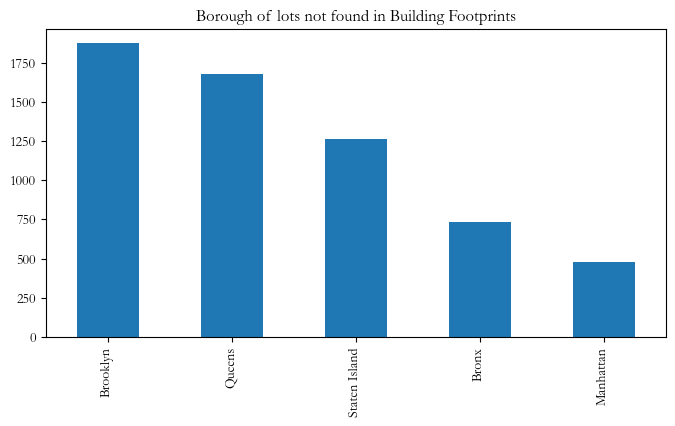

In [7]:
print(f"Buildings not found in Building Footprint: {only_in_pluto.shape[0]}")
only_in_pluto.borough.value_counts().plot.bar(title = "Borough of lots not found in Building Footprints", figsize = (8,4));

Buildings not found in PLUTO: 14410


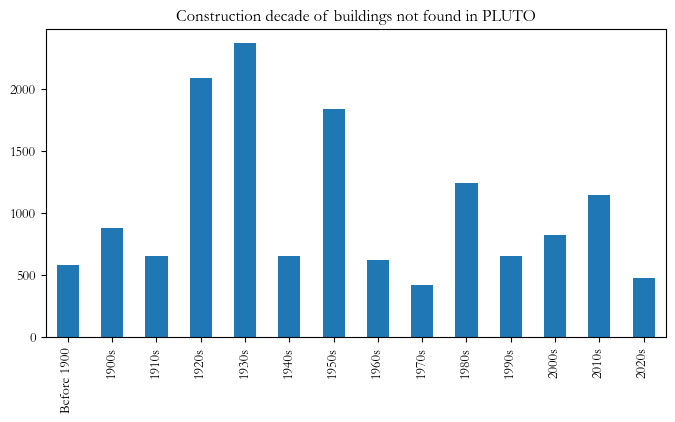

In [8]:
print(f"Buildings not found in PLUTO: {only_in_building_footprints.shape[0]}")
only_in_building_footprints.cnstrct_yr_intervals.value_counts().sort_index().plot.bar(title = "Construction decade of buildings not found in PLUTO", figsize = (8,4));

##### Keep only BBL matches

In [ ]:
buildings_and_landuse = buildings_and_landuse.query("_merge == 'both'").copy()
buildings_and_landuse.cnstrct_yr = buildings_and_landuse.cnstrct_yr.astype("int64")

# Dimensions of dataset 
buildings_and_landuse.shape

# Data Analysis<a id="Data_Analysis"></a>

# Genre<a id="Genre"></a>

# Visualization<a id="Visualization"></a>


# Discussion<a id="Discussion"></a>


# Contribution<a id="Contribution"></a>


# References<a id="References"></a>

## Plot Data

Plot Construction in different periods

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (8,8))

# Early plot 
new_york_boroughs_map.plot(color = "white", edgecolor = "black", alpha = 0.5, ax = ax[0][0])
buildings_and_landuse.query("cnstrct_yr < 1900").plot(markersize = 1, color = "#E9655C", alpha = 0.1, ax = ax[0][0])
ax[0][0].set_title("Construction before 1900", size = 20)
ax[0][0].set_axis_off()

# Middle plot 
new_york_boroughs_map.plot(color = "white", edgecolor = "black", alpha = 0.5, ax = ax[0][1])
buildings_and_landuse.query("cnstrct_yr >= 1900 & cnstrct_yr < 1940").plot(markersize = 1, color = "#E9655C", alpha = 0.1, ax = ax[0][1])
ax[0][1].set_title("Construction between 1900 and 1940", size = 20)
ax[0][1].set_axis_off()

# Early plot 
new_york_boroughs_map.plot(color = "white", edgecolor = "black", alpha = 0.5, ax = ax[1][0])
buildings_and_landuse.query("cnstrct_yr >= 1940 & cnstrct_yr < 1980").plot(markersize = 1, color = "#E9655C", alpha = 0.1, ax = ax[1][0])
ax[1][0].set_title("Construction between 1940 and 1980", size = 20)
ax[1][0].set_axis_off()

# Middle plot 
new_york_boroughs_map.plot(color = "white", edgecolor = "black", alpha = 0.5, ax = ax[1][1])
buildings_and_landuse.query("cnstrct_yr >= 1980").plot(markersize = 1, color = "#E9655C", alpha = 0.1, ax = ax[1][1])
ax[1][1].set_title("Construction after 1980", size = 20)
ax[1][1].set_axis_off()

plt.tight_layout()
plt.show()

Plot Construction by decade 

In [ ]:
construction_by_year = buildings_and_landuse.groupby("cnstrct_yr_intervals").size().sort_index()

fig, ax  = plt.subplots(figsize = (10,6))
construction_by_year.plot.bar(color = "#E9655C", alpha = 0.8, width = 0.8)
ax.set_title("Construction by Decade", size = 22)
ax.set_ylabel("Buildings", size = 20)
ax.set_xlabel("")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("Plots/construction_by_decade.png", dpi = 300, bbox_inches = "tight")
plt.show()


By land use! 

In [ ]:
''' Make a stacked barplot here, divided into land use '''

### Plots By Bourough 

Removed early observations 

In [ ]:
# Removed early observations 
buildings_and_landuse_trimmed = buildings_and_landuse.query("cnstrct_yr >= 1800").copy()

In [ ]:
#https://github.com/mwaskom/seaborn/issues/2280
# Ændre position af sns legend 
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legend_handles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text().title()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

Set xtick frequency (and labels, if necesarry)

In [ ]:
## OBS - Kan bruges til at ændre xticts, men er ikke nødvendigt ift. position og label (i nedenstående er label og position dog det samme)
custom_xticks_label = []
custom_xticks_position = []

for position, year_label in enumerate(sorted(buildings_and_landuse_trimmed.cnstrct_yr.unique())):
    if year_label%10==0:
        custom_xticks_label.extend([year_label])
        custom_xticks_position.extend([position])

In [ ]:
fig, ax  = plt.subplots(figsize = (10,5))
plt.rcParams['legend.title_fontsize'] = 'x-large'

sns.kdeplot(buildings_and_landuse_trimmed, x ="cnstrct_yr", hue = "borough", multiple = "stack", bw_adjust= 1.5, common_norm = True, linewidth = 0, zorder=1, ax = ax)
move_legend(ax, "upper left", fontsize = "x-large")
custom_xticks_position = custom_xticks_label # because x is numerical
ax.set_xticks(ticks = custom_xticks_position, labels=custom_xticks_label, rotation=90)
#ax.axvspan(xmin=1920, xmax=1930, color='#B6B9BB', alpha=0.5, zorder=0)
ax.set_xlim([1800, 2030])
ax.set_title("Construction by Year and Borough", size = 22)

ax.set_ylabel("Density of Probability", size = 20)
ax.set_xlabel("")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("Plots/construction_distribution_by_borough.png", dpi = 300, bbox_inches = "tight")
plt.tight_layout()
plt.show()

In [ ]:
# fig, ax  = plt.subplots(figsize = (10,6))

# sns.kdeplot(buildings_and_landuse_trimmed, x ="cnstrct_yr", hue = "borough", multiple = "stack", bw_adjust= 1.5, common_norm = True, linewidth = 0, cumulative = True,  ax = ax)
# move_legend(ax, "upper left")
# custom_xticks_position = custom_xticks_label # because x is numerical
# ax.set_xticks(ticks = custom_xticks_position, labels=custom_xticks_label, rotation=90)
# ax.set_xlim([1800, 2030])
# ax.set_title("Cumulative Construction by Year and Bourough")

# plt.tight_layout()
# plt.show()

## By Square Feet 

Documentation: 
- COMMERCIAL FLOOR AREA is the sum of floor areas for office, retail, garage,
storage, factory, and other uses.